# Chapter 5. Sampling, periodicity and crystals

Calculate an isosurface of caffeine at a low level, something like 0.5 electrons/$\overset{\circ}{\text{A}}$$^3$. You may already have noticed that a slice is missing from one of the atoms. Look at the other side of the molecule, and you'll find the slice there (hanging in mid-air). Can you think of an explanation?.

In [1]:
%%capture
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

# add path to the Modules
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

from Reconstruction import *
mlab.init_notebook('x3d')

In [2]:
cutoff = 2
step = 1./8
H, K, L = xyzgrid(cutoff, step)

In [3]:
caf = Molecule('caffeine.pdb')
F = moltrans(caf, H,K,L)

# Compute Gaussian window
sigma = 1
G = np.exp(-(H**2 + K**2 + L**2)/(2*sigma**2))
# Multiply the molecular transform with the window.
F = F*G

rho = fft.fftshift(abs(fft.ifftn(F, [2**6, 2**6, 2**6])))
rhoScale = step**3 * np.prod(rho.shape)
rho = rho * rhoScale

In [4]:
isosurface(rho, 0.5)

Leave the three-dimensional stuff for now, and recreate the two-dimensional projection from the first exercise. Use a cut-off of 8 to get decently sharp atoms, and use **subplot** to display four projections created with the step sizes 1/8, 1/7, 1/6 and 1/5. <span style="color:blue">What happens as you decrease the step size?</span> Look at an atom near an edge and follow it as the step size decreases.

In [5]:
def transform(mol, step, cutoff):
    """
    Wrap up some of the commonly used commands.
    """
    H, K, L = TwoD_grid(step, cutoff)
    F = moltrans(mol, H,K,L)
    rho = np.fliplr(fft.fftshift(abs(fft.ifftn(F, [2**10, 2**10]))))
    
    # rescale
    rhoScale = step**3 * np.prod(rho.shape)
    rho = rho * rhoScale
    
    return rho

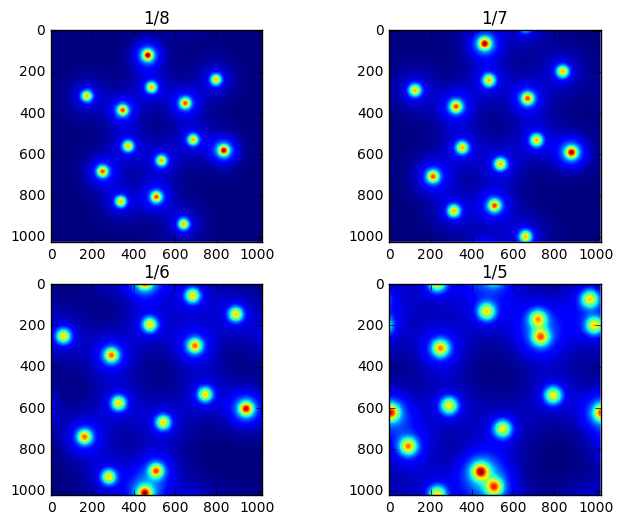

In [6]:
fig, ax = plt.subplots(2, 2)
ax[0,0].imshow(transform(caf, 1./8, 8), interpolation='none')
ax[0,0].set_title('1/8')
ax[0,1].imshow(transform(caf, 1./7, 8), interpolation='none')
ax[0,1].set_title('1/7')
ax[1,0].imshow(transform(caf, 1./6, 8), interpolation='none')
ax[1,0].set_title('1/6')
ax[1,1].imshow(transform(caf, 1./5, 8), interpolation='none')
ax[1,1].set_title('1/5')

The explanation, again, is given by the convolution theorem. However, first we need to introduce the sampling/replicating function *sha*

$$
\text{III}(x) = \sum_{n=-\infty}^{\infty} \delta(x-n)
$$

The sha-function is essentially an array of delta functions (impulses) with unit strength and unit spacing. It is also called the *sampling function* because when you multiply a continuous function with sha, you extract a set of uniformly spaced samples from that function (this is a useful way to treat discrete mathematics in a continuous framework). We can represent an array of unit impulses with spacing $a$ as

$$
\frac{1}{|a|} \text{III} \left( \frac{x}{a} \right) = \frac{1}{|a|} \sum_{n=-\infty}^{\infty} \delta \left( \frac{x}{a} - n \right) = \sum_{n=-\infty}^{\infty} \delta(x-an)
$$

and extract a set of samples with spacing $a$ from the molecular transform by writing

$$
F_{\text{discrete}} = \frac{1}{|a|} \text{III} \left( \frac{x}{a} \right) F(k).
$$

So, how does this multiplication affect the electron density? Enter the convolution theorem. The sha function has the useful property that it is its own Fourier transform. Scaling with a factor $a$ propagates between the spaces according to the similarity theorem (which you probably have learned at some point). Anyway, the end result is:

$$
\rho_{\text{periodic}} = \rho(x) * \text{III}(ax)
$$

In words, **sampling the molecular transform with spacing $a$ is equivalent to convoluting the electron density with an array of delta functions with spacing $1/a$**. I have used the suffix *periodic* because the effect of this convolution is to erect a complete copy of the electron density *around each delta function*, creating a periodic function. Thus, **sampling the molecular transform with spacing $a$ is equivalent to periodically repeating the electron density in real space**. The period of the repeat is $1/a$.

When you execute the FFT (fast Fourier transform), it will calculate a single repeat for you and it is taken for granted that you know that the result is periodic. In the plots you made above, you gradually decreased the sampling distance **a = step** until the resulting period in real space (**1/a = 1/step**) was so small that **adjacent repeats of the electron density started to overlap**. This is called aliasing (vikningsdistortion in swedish). It is the same phenomena as the distortion you hear when music is sampled at a too low bit rate.

<span style="color:blue">Do you now see why you used the default sampling step of 1/8 for the caffeine molecule?</span> (Recall the very first question of the tutorial.) In fact, a sampling step of 1/8 is just a little too large. That is why you could see a slice of an atom being cut off and inserted on the other side.

- <span style="color:blue">By reversing the above argument, can you explain why a crystalline diffraction pattern is discrete rather than continuous (the so-called Bragg peaks)? What property of the unit cell determines the spacing between the Bragg peaks?</span>

- Extra: Do you see why a periodic function can be represented by a Fourier series whereas a non-periodic function must be represented by a Fourier integral? Can you see that the sha function is the link between Fourier series and Fourier integrals?